# LSTM
**Content:**
- Google Colab Setup
- Preprocessing
- Modeling
- Evaluation
- Conclusion

In [1]:
# util.py has pmdarima function inside
# Need to install it before import the pyfile
# !pip install pmdarima

## I. Goole Colab Setup

In [2]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pickle import dump, load

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Keras, Tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [3]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
# Get the current working directory
print(os.getcwd())

/content


In [5]:
# Drive path is the path where I upload the ETFs history file and pre-written pyfile
drive_path_csv = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'
drive_path_util = '/gdrive/MyDrive/Capstone_Project/util.py'

# Expect to move these file into the local path
local_path = '/content'

In [6]:
# Copy these file in drive path
!cp '{drive_path_csv}' .
!cp '{drive_path_util}' .

# Change these file from drive path to the local path
os.chdir(local_path)

In [7]:
# Pre-written function
import util as ut

## II. Preprocesing

In [8]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.280000,9.290000,9.220000,9.220000,5200,0.0,0.0,REK
53435,2021-06-18,9.330000,9.370000,9.270000,9.370000,22800,0.0,0.0,REK
53436,2021-06-21,9.320000,9.320000,9.170000,9.170000,22900,0.0,0.0,REK
53437,2021-06-22,9.160000,9.230000,9.160000,9.220000,6200,0.0,0.0,REK


In [9]:
# Select one REIT ETF
vnq = data.copy().loc[data['Ticker'] == "VNQ"]

In [10]:
# Preprocess the dataframe
ut.preprocess_df(vnq)

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...
2021-06-17,103.410004,103.699997,102.860001,103.550003,5055100,0.0,0.0,VNQ
2021-06-18,103.019997,103.470001,101.790001,101.790001,5358000,0.0,0.0,VNQ
2021-06-21,102.309998,104.209999,101.800003,103.889999,3672900,0.0,0.0,VNQ


In [11]:
# Split the data into train, validation, and test set
# Test size = 1 month (22 days)
# Val size = 1 year (253 days)
# Train size = rest of the time
train = vnq['Close'].iloc[:-275]
val = vnq['Close'].iloc[-275:-22]
test = vnq['Close'].iloc[-22:]

In [12]:
print("Train: date from {} to {}, total of {} days".format(train.index[0],train.index[-1], len(train)))
print("Val: date from {} to {}, total of {} days".format(val.index[0],val.index[-1], len(val)))
print("Test: date from {} to {}, total of {} days".format(test.index[0],test.index[-1], len(test)))

Train: date from 2004-09-29 00:00:00 to 2020-05-20 00:00:00, total of 3938 days
Val: date from 2020-05-21 00:00:00 to 2021-05-21 00:00:00, total of 253 days
Test: date from 2021-05-24 00:00:00 to 2021-06-23 00:00:00, total of 22 days


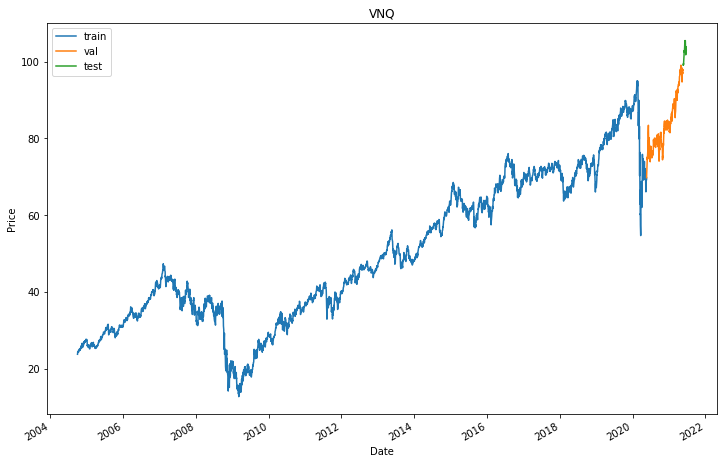

In [13]:
plt.figure(figsize=(12,8))
train.plot()
val.plot()
test.plot()
plt.title("VNQ")
plt.ylabel("Price")
plt.legend(['train', 'val', 'test'])
plt.show()

In [14]:
# Scale the data
scaler = MinMaxScaler()

train_scale = scaler.fit_transform(train.values.reshape(-1,1))
val_scale = scaler.transform(val.values.reshape(-1,1))
test_scale = scaler.transform(test.values.reshape(-1,1))

In [15]:
# Save the scaler (for future use)
# dump(scaler, open('/content/scaler.pkl', 'wb'))

# Load the scaler (if run in another notebook)
# sc = load(open('/content/scaler.pkl', 'rb'))

In [16]:
# Define a function to split the dataset into X and y part
def xy_split (dataset, timestep):
    '''
    Split the time series into X and y part based on the number of timestep.
    Ex. Use n days to predict the next preceding day (n+1) price.
    
    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - dataset: Time series data
    - timestep: number of days in integer
    
    Return: 
    - X_part, y_part (in arrays)
    '''
    
    X_part, y_part = [], []
    
    for i in range(len(dataset)-timestep-1):
         
        X_part.append(dataset[i:(i+timestep)])

        y_part.append(dataset[i+timestep])

    return np.array(X_part), np.array(y_part)

## III. Modeling
Metric used:
- MAE
- RMSE
- R^2

### Baseline Model

In [17]:
# X,y split with timestep of 1
X_train, y_train = xy_split(train_scale, timestep=1)
X_val, y_val = xy_split(val_scale, timestep=1)
X_test, y_test = xy_split(test_scale, timestep=1)

In [18]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (3936, 1, 1)
y_train shape:  (3936, 1)
X_val shape:  (251, 1, 1)
y_val shape:  (251, 1)
X_test shape:  (20, 1, 1)
y_test shape:  (20, 1)


### Early Stopping
- Since the validation set is much smaller than train set, the validation curves (accuracy and loss) will be spiky before convergence. Early stopping will be applied to prevent model loss


In [19]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)  # early stopping when MSE reaches minimum

In [20]:
# Build the model
base_model = Sequential()
base_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:])))
base_model.add(LSTM(50))
base_model.add(Dense(units=1))

# Compile the model
base_model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Model Checkpoint
mc_base = ModelCheckpoint(filepath='/content/t1_u50.h5',
                          monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [23]:
# Fit the model
base_model.fit(X_train, y_train, batch_size=23, epochs=50,
               validation_data=(X_val, y_val),
               callbacks=[es, mc_base])

Epoch 1/50
172/172 [==============================] - 4s 8ms/step - loss: 0.0467 - val_loss: 0.0019

Epoch 00001: val_loss improved from inf to 0.00194, saving model to /content/t1_u50.h5
Epoch 2/50
172/172 [==============================] - 1s 4ms/step - loss: 5.9753e-04 - val_loss: 0.0016

Epoch 00002: val_loss improved from 0.00194 to 0.00160, saving model to /content/t1_u50.h5
Epoch 3/50
172/172 [==============================] - 1s 4ms/step - loss: 3.2135e-04 - val_loss: 0.0010

Epoch 00003: val_loss improved from 0.00160 to 0.00100, saving model to /content/t1_u50.h5
Epoch 4/50
172/172 [==============================] - 1s 4ms/step - loss: 2.6117e-04 - val_loss: 7.5382e-04

Epoch 00004: val_loss improved from 0.00100 to 0.00075, saving model to /content/t1_u50.h5
Epoch 5/50
172/172 [==============================] - 1s 4ms/step - loss: 2.0064e-04 - val_loss: 5.2968e-04

Epoch 00005: val_loss improved from 0.00075 to 0.00053, saving model to /content/t1_u50.h5
Epoch 6/50
172/172 [

In [24]:
base_y_val_true, base_y_val_inv = ut.lstm_model_evaluation(base_model, scaler, X_train, y_train, X_val, y_val)

Train results: 
MAE: 0.6614
RMSE: 0.8826
R^2: 0.9978
None


Val results: 
MAE: 1.0129
RMSE: 1.2517
R^2: 0.9667
None


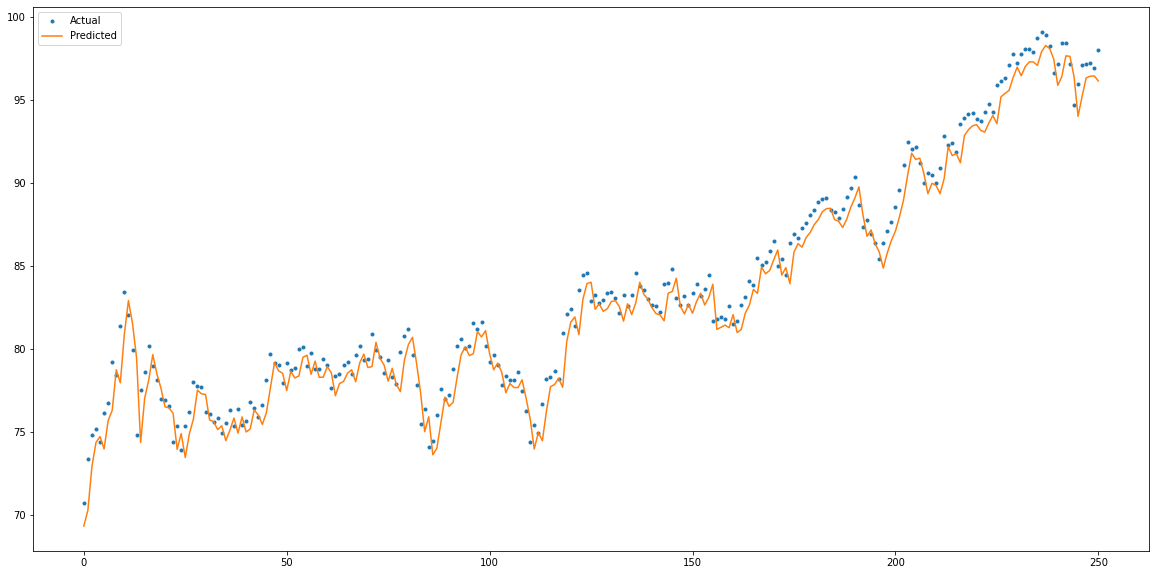

In [25]:
ut.lstm_plot_prediction(base_y_val_true, base_y_val_inv)

>**Comment:** *Baseline Model*
- Val R2 (0.9667) is slightly less than train R2 0.9978 => slightly overfit
- Both MAE and RMSE for train and val are relative small
- The plot shows that the prediction results is pretty close to actual price

### Tuning Steps
- Timestep changing
- Number of input featuers
- Increase the depth of the model

#### a)Time Steps

##### timestep = 5

In [26]:
# X,y split with timestep of 5
X_train_5, y_train_5 = xy_split(train_scale, timestep=5)
X_val_5, y_val_5 = xy_split(val_scale, timestep=5)

In [27]:
# Build the model
t5_model = Sequential()
t5_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_5.shape[1:])))
t5_model.add(LSTM(50))
t5_model.add(Dense(units=1))

# Compile the model
t5_model.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
# Model Checkpoint
mc_t5 = ModelCheckpoint(filepath='/content/t5_u50.h5',
                        monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [29]:
# Fit the model
t5_model.fit(X_train_5, y_train_5, batch_size=23, epochs=50,
             validation_data=(X_val_5, y_val_5),
             callbacks=[es, mc_t5])

Epoch 1/50
171/171 [==============================] - 5s 12ms/step - loss: 0.0197 - val_loss: 7.7946e-04

Epoch 00001: val_loss improved from inf to 0.00078, saving model to /content/t5_u50.h5
Epoch 2/50
171/171 [==============================] - 1s 7ms/step - loss: 3.1372e-04 - val_loss: 4.7065e-04

Epoch 00002: val_loss improved from 0.00078 to 0.00047, saving model to /content/t5_u50.h5
Epoch 3/50
171/171 [==============================] - 1s 8ms/step - loss: 2.6501e-04 - val_loss: 5.0211e-04

Epoch 00003: val_loss did not improve from 0.00047
Epoch 4/50
171/171 [==============================] - 1s 8ms/step - loss: 2.4403e-04 - val_loss: 4.9924e-04

Epoch 00004: val_loss did not improve from 0.00047
Epoch 5/50
171/171 [==============================] - 1s 8ms/step - loss: 2.2496e-04 - val_loss: 4.8397e-04

Epoch 00005: val_loss did not improve from 0.00047
Epoch 6/50
171/171 [==============================] - 1s 8ms/step - loss: 2.3162e-04 - val_loss: 4.6098e-04

Epoch 00006: val_l

In [30]:
t5_y_val_true, t5_y_val_inv = ut.lstm_model_evaluation(t5_model, scaler, X_train_5, y_train_5, X_val_5, y_val_5)

Train results: 
MAE: 0.7877
RMSE: 1.1761
R^2: 0.9961
None


Val results: 
MAE: 1.5363
RMSE: 1.9042
R^2: 0.9214
None


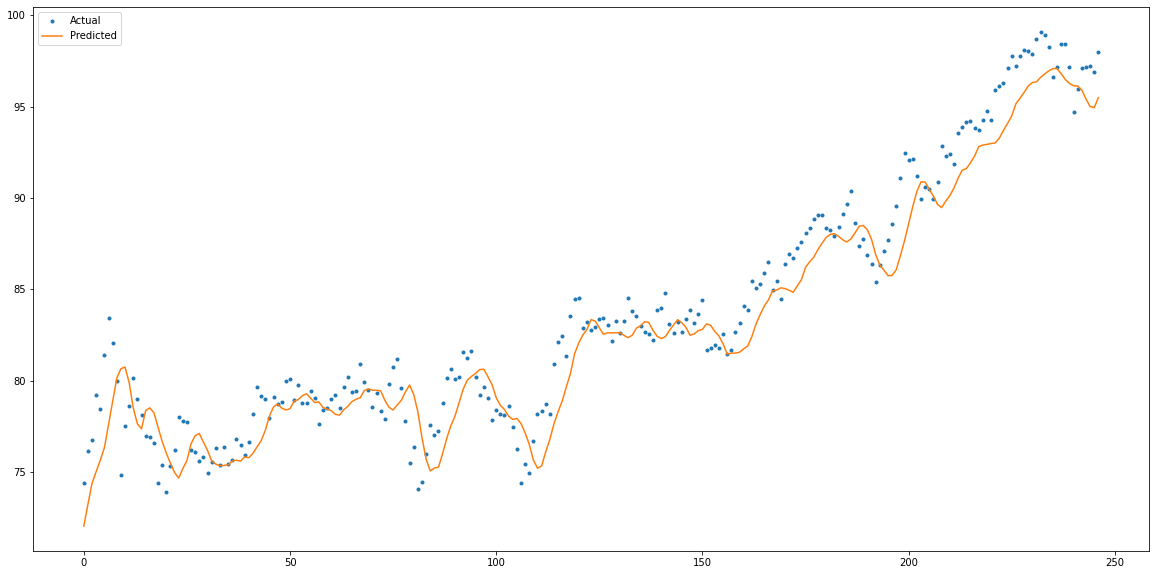

In [31]:
ut.lstm_plot_prediction(t5_y_val_true, t5_y_val_inv)

>**Comment:** *timestep = 5*
- Val R2 (0.9214) is slightly less than train R2 (0.9961) => slightly overfit
- Both MAE and RMSE for train and val are relative small
- The plot shows that the prediction results can track the pattern but it's somewhat far away from the actual price

##### timestep = 21

In [32]:
# X,y split with timestep of 21
X_train_21, y_train_21 = xy_split(train_scale, timestep=21)
X_val_21, y_val_21 = xy_split(val_scale, timestep=21)

In [33]:
# Build the model
t21_model = Sequential()
t21_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_21.shape[1:])))
t21_model.add(LSTM(units=50))
t21_model.add(Dense(units=1))

# Compile the model
t21_model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
# Model Checkpoint
mc_t21 = ModelCheckpoint(filepath='/content/t21_u50.h5',
                         monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [35]:
# Fit the model
t21_model.fit(X_train_21, y_train_21, batch_size=23, epochs=50,
              validation_data=(X_val_21, y_val_21),
              callbacks=[es, mc_t21])

Epoch 1/50
171/171 [==============================] - 8s 25ms/step - loss: 0.0111 - val_loss: 7.5738e-04

Epoch 00001: val_loss improved from inf to 0.00076, saving model to /content/t21_u50.h5
Epoch 2/50
171/171 [==============================] - 4s 21ms/step - loss: 4.3872e-04 - val_loss: 6.6505e-04

Epoch 00002: val_loss improved from 0.00076 to 0.00067, saving model to /content/t21_u50.h5
Epoch 3/50
171/171 [==============================] - 4s 21ms/step - loss: 4.1297e-04 - val_loss: 6.7826e-04

Epoch 00003: val_loss did not improve from 0.00067
Epoch 4/50
171/171 [==============================] - 4s 21ms/step - loss: 3.9655e-04 - val_loss: 6.0660e-04

Epoch 00004: val_loss improved from 0.00067 to 0.00061, saving model to /content/t21_u50.h5
Epoch 5/50
171/171 [==============================] - 4s 21ms/step - loss: 4.5666e-04 - val_loss: 5.3631e-04

Epoch 00005: val_loss improved from 0.00061 to 0.00054, saving model to /content/t21_u50.h5
Epoch 6/50
171/171 [===================

In [36]:
t21_y_val_true, t21_y_val_inv = ut.lstm_model_evaluation(t21_model, scaler, X_train_21, y_train_21, X_val_21, y_val_21)

Train results: 
MAE: 1.3377
RMSE: 1.6635
R^2: 0.9921
None


Val results: 
MAE: 2.5938
RMSE: 2.9419
R^2: 0.8157
None


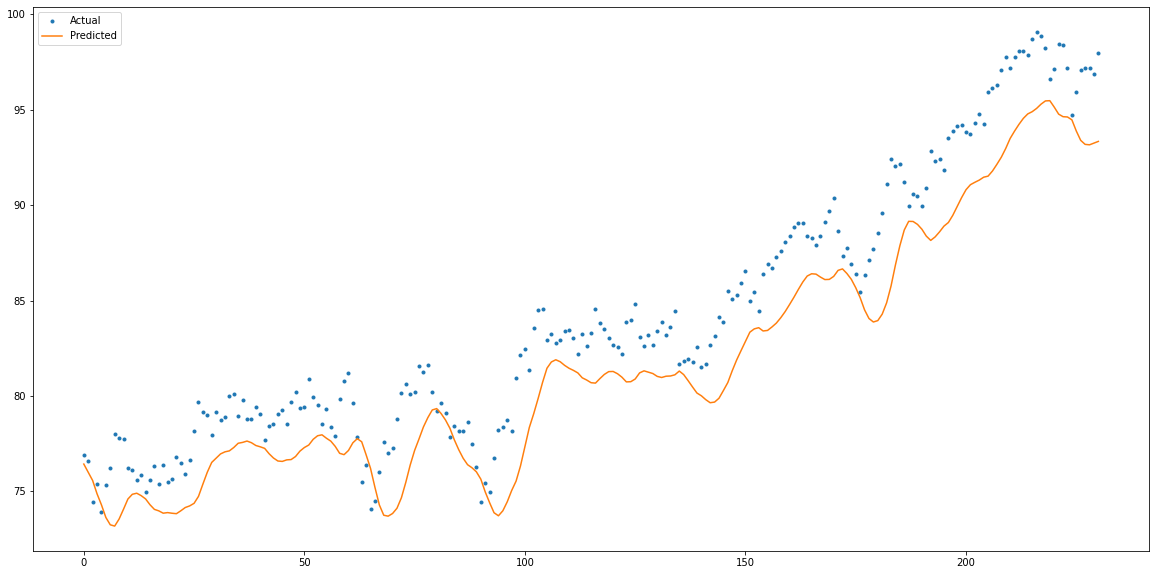

In [37]:
ut.lstm_plot_prediction(t21_y_val_true, t21_y_val_inv)

>**Comment:** *timestep = 21*
- Val R2 (0.8157) is less than train R2 (0.9921) => overfit
- Both MAE and RMSE for train and val are small. But the errors are bigger than baseline model's result
- The plot shows that the prediction results can track the pattern but it's far away from the actual price

#### Timestep Choosing
- Increasing the time step can not improve the model performance. Although it can track the price pattern, the predicted results would become far away from the actual price when increasing the timestep
- <b>timestep = 1</b> (baseline model) will be used for further model tuning

#### b) Input Features

##### Grid Search

In [38]:
def feature_model(features):
    '''
    Create a LSTM model with custom input features.

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - fetures: integer

    Return:
    - Custom model
    '''

    # Build the model
    model = Sequential()
    model.add(LSTM(units=features, return_sequences=True, input_shape=(X_train.shape[1:])))
    model.add(LSTM(units=features))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
  
    return model

In [39]:
# Wrapper
f_model = KerasRegressor(build_fn=feature_model)

In [40]:
# Input features
f = [50, 100, 150, 200, 250, 300]

# Parameter grid
f_param_grid = dict(features = f)

In [41]:
# Grid Search
f_grid = GridSearchCV(f_model, param_grid = f_param_grid, cv=3)

In [42]:
f_grid_history = f_grid.fit(X_train, y_train,
                            batch_size=23, epochs=50,
                            validation_data=(X_val, y_val),
                            callbacks=es,
                            verbose=0)

Epoch 00009: early stopping
41/41 [==============================] - 1s 2ms/step - loss: 9.9429e-04
Epoch 00026: early stopping
41/41 [==============================] - 1s 2ms/step - loss: 3.8632e-05
Epoch 00026: early stopping
41/41 [==============================] - 1s 2ms/step - loss: 1.4186e-04
Epoch 00008: early stopping
41/41 [==============================] - 1s 2ms/step - loss: 4.9124e-04
Epoch 00024: early stopping
41/41 [==============================] - 1s 3ms/step - loss: 8.8213e-05
Epoch 00024: early stopping
41/41 [==============================] - 1s 2ms/step - loss: 1.7326e-04
Epoch 00023: early stopping
41/41 [==============================] - 1s 3ms/step - loss: 7.2445e-05
Epoch 00019: early stopping
41/41 [==============================] - 1s 2ms/step - loss: 4.0194e-05
Epoch 00024: early stopping
41/41 [==============================] - 1s 2ms/step - loss: 1.3977e-04
Epoch 00026: early stopping
41/41 [==============================] - 1s 3ms/step - loss: 8.1192e-05


In [43]:
# Find the best parameter
f_grid_history.best_params_

{'features': 150}

In [44]:
# Number of features
n_features = f_grid_history.best_params_['features']
n_features

150

##### input features = 150

In [49]:
model_f150 = feature_model(n_features)

In [50]:
mc_f150 = ModelCheckpoint(filepath='/content/f150.h5',
                          monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [51]:
model_f150.fit(X_train, y_train, batch_size=23, epochs=50,
               validation_data=(X_val, y_val),
               callbacks=[es, mc_f150])

Epoch 1/50
172/172 [==============================] - 5s 12ms/step - loss: 0.0251 - val_loss: 7.7644e-04

Epoch 00001: val_loss improved from inf to 0.00078, saving model to /content/f150.h5
Epoch 2/50
172/172 [==============================] - 1s 8ms/step - loss: 1.9355e-04 - val_loss: 4.0308e-04

Epoch 00002: val_loss improved from 0.00078 to 0.00040, saving model to /content/f150.h5
Epoch 3/50
172/172 [==============================] - 1s 8ms/step - loss: 1.6115e-04 - val_loss: 3.9721e-04

Epoch 00003: val_loss improved from 0.00040 to 0.00040, saving model to /content/f150.h5
Epoch 4/50
172/172 [==============================] - 1s 7ms/step - loss: 1.3038e-04 - val_loss: 3.2161e-04

Epoch 00004: val_loss improved from 0.00040 to 0.00032, saving model to /content/f150.h5
Epoch 5/50
172/172 [==============================] - 1s 8ms/step - loss: 1.0894e-04 - val_loss: 2.6634e-04

Epoch 00005: val_loss improved from 0.00032 to 0.00027, saving model to /content/f150.h5
Epoch 6/50
172/17

In [52]:
f150 = load_model('/content/f150.h5')

In [53]:
f150_y_val_true, f150_y_val_inv = ut.lstm_model_evaluation(f150, scaler, X_train, y_train, X_val, y_val)

Train results: 
MAE: 0.4878
RMSE: 0.7660
R^2: 0.9983
None


Val results: 
MAE: 0.8256
RMSE: 1.0741
R^2: 0.9755
None


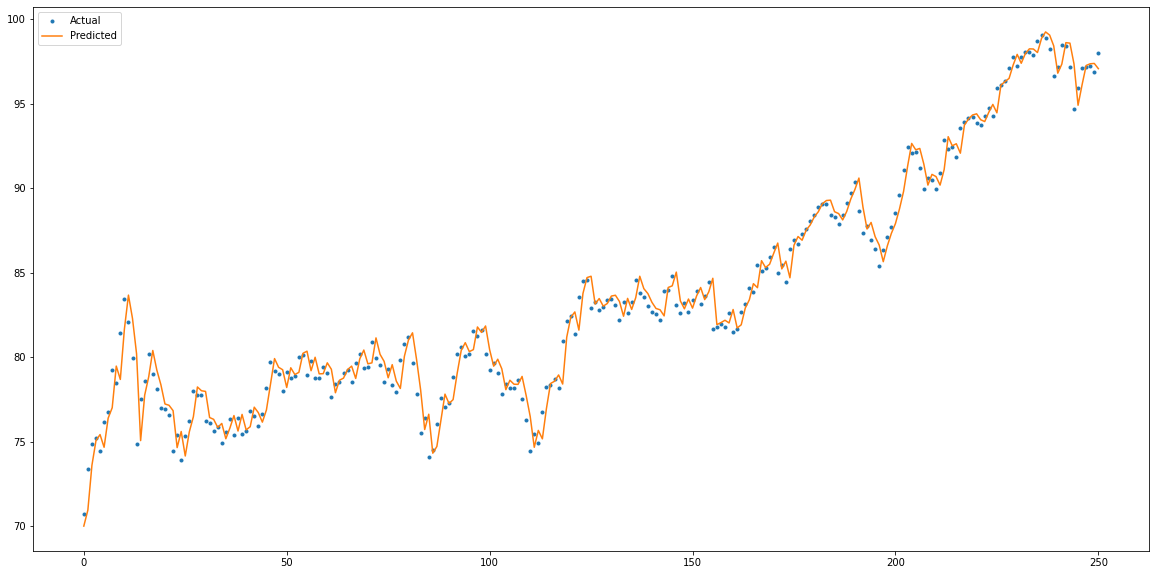

In [56]:
ut.lstm_plot_prediction(f150_y_val_true, f150_y_val_inv)

>**Comment:** *input feature = 150*
- The R2 of f150 (0.9755) shows improvement compare with the baseline model (0.9667) 
- Both MAE and RMSE for f150 (0.8256, 1.0741) is less than the baseline model (1.0129, 1.2517)
- The plot shows that the prediction results is pretty close to actual price. More points are predicted compare with baseline model

#### c) Layers

In [57]:
def stack_model(layers):
    '''
    Create a LSTM with custom hidden layers.
    
    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - layers: interger (number of hidden layers)
    
    Return:
    - Custome model

    '''
    if layers == 2:
        # Build the model
        model = Sequential()
        model.add(LSTM(units=n_features, return_sequences=True, input_shape=(X_train.shape[1:])))
        model.add(LSTM(units=n_features))
        model.add(Dense(units=1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
    
        return model
    
    elif layers == 3:
        # Build the model
        model = Sequential()
        model.add(LSTM(units=n_features, return_sequences=True, input_shape=(X_train.shape[1:])))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features))
        model.add(Dense(units=1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
    
        return model
    
    elif layers == 4:
        # Build the model
        model = Sequential()
        model.add(LSTM(units=n_features, return_sequences=True, input_shape=(X_train.shape[1:])))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features))
        model.add(Dense(units=1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
    
        return model
    
    elif layers == 5:
        # Build the model
        model = Sequential()
        model.add(LSTM(units=n_features, return_sequences=True, input_shape=(X_train.shape[1:])))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features))
        model.add(Dense(units=1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
    
        return model
    
    else:
        print("Please select number of layers betweeen 2 to 5.")

##### Grid Search

In [58]:
# Wrapper
s_model = KerasRegressor(build_fn=stack_model)

In [59]:
s = [2, 3, 4, 5]

# Parameter grid
s_param_grid = dict(layers = s)

In [60]:
# Grid Search
s_grid = GridSearchCV(s_model, param_grid = s_param_grid, cv=3)

In [61]:
s_grid_history = s_grid.fit(X_train, y_train,
                            batch_size=23, epochs=50,
                            validation_data=(X_val, y_val),
                            callbacks=es,
                            verbose=0)

Epoch 00028: early stopping
41/41 [==============================] - 1s 2ms/step - loss: 7.2577e-05
Epoch 00020: early stopping
41/41 [==============================] - 1s 2ms/step - loss: 6.1224e-05
Epoch 00028: early stopping
41/41 [==============================] - 1s 2ms/step - loss: 1.4514e-04
Epoch 00021: early stopping
41/41 [==============================] - 1s 3ms/step - loss: 1.4664e-04
Epoch 00023: early stopping
41/41 [==============================] - 1s 3ms/step - loss: 1.5600e-04
Epoch 00016: early stopping
41/41 [==============================] - 1s 3ms/step - loss: 1.6369e-04
Epoch 00016: early stopping
41/41 [==============================] - 1s 4ms/step - loss: 1.8863e-04
Epoch 00019: early stopping
41/41 [==============================] - 2s 4ms/step - loss: 7.3169e-05
Epoch 00012: early stopping
41/41 [==============================] - 1s 4ms/step - loss: 2.5300e-04
Epoch 00012: early stopping
41/41 [==============================] - 2s 4ms/step - loss: 1.7939e-04


In [62]:
s_grid_history.best_params_

{'layers': 2}

#### Layer Choosing
- The grid search results indicate that the LSTM model with: generates the best results
    - timestep = 1
    - input features = 150
    - 2 hidden layer


### IV.Evaluation
- Prediction on true holdout test set

In [63]:
# Load model (if run in another notebook)
best = load_model('/content/f150.h5')

In [64]:
# Make prediction on the holdout test set
y_test_pred = best.predict(X_test)

# Inverse transform the test prediction and actual
y_test_inv = scaler.inverse_transform(y_test_pred)
y_test_true = scaler.inverse_transform(y_test)

In [65]:
ut.evaluate(y_test_true, y_test_inv)

MAE: 0.7335
RMSE: 0.9228
R^2: 0.7897


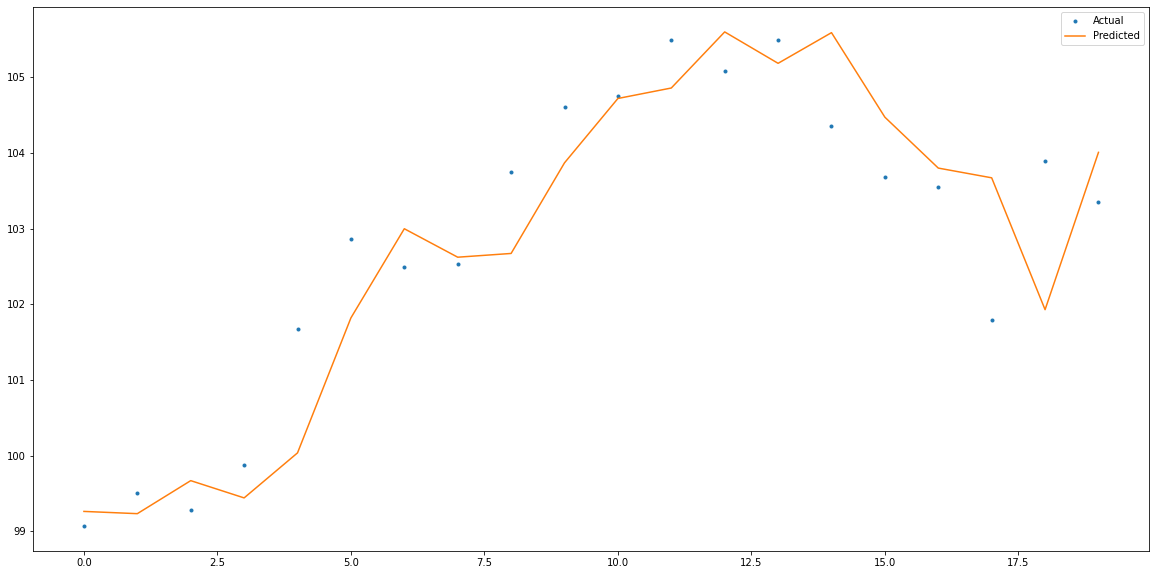

In [66]:
ut.lstm_plot_prediction(y_test_true, y_test_inv)

>**Comment:** *f150*
- Test R2 is (0.7897)
- Both MAE and RMSE for test results are relative small
- The plot shows that the prediction results can track the pattern but it's slightly far away from the actual price

## V. Conclusion
- Among analyze 4213 historical data from VNQ, LSTM model <b>f150</b> generates the best results
- True holdout test R2 reaches 0.7897, MAE and RMSE (0.7335, 0.9228) are relative small
- The prediction results are unseen data is acceptable